# Import

In [1]:
import numpy as np
from scipy.stats import norm
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import statistics
from scipy import signal
from scipy.optimize import curve_fit
import scipy.fftpack
from scipy import interpolate
from cycler import cycler
from inspect import signature

In [39]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
%matplotlib notebook

# Reading data

In [3]:
#reading routine
def read_data_file(common_folder, folder_in, Rl, N, file_type, spec_type, spec_component, run_files) :
    nb_of_runs = len(run_files)
    for run_index in list(range(nb_of_runs)) :
        folder = common_folder + "rl" + str(Rl) + "_N" + str(N) + "/" + folder_in + "run" + "%01d" % (run_index+1) + "/"
        if (run_files[run_index] < 1000) :
            file = folder + file_type + "_" + spec_type + "_C" + spec_component + "_wi=" + "%03d" % run_files[run_index] + ".table"
        else : 
            file = folder + file_type + "_" + spec_type + "_C" + spec_component + "_wi=" + "%06d" % run_files[run_index] + ".table"
        file_data = []
        print('reading file: ' + file)
        averaging_weight = (run_files[run_index]+1)/(sum(run_files)+nb_of_runs)
        for line in open(file) :
            temp_array_line = []
            if line[0] == '#' :          #skip commented lines
                continue
            else :
                temp_array_line=list(map(float, line.split( )))
                temp_array_line = [t * averaging_weight for t in temp_array_line]
                file_data.append(temp_array_line)  
        if (run_index == 0) : 
            accumulated_data = file_data.copy()
        else : 
            accumulated_data = list(map(lambda l1, l2: [sum(x) for x in zip(l1, l2)], accumulated_data, file_data))
    k = np.array(accumulated_data[0])
    nb_of_modes = np.array(accumulated_data[1])
    average_data = np.ndarray(shape=(len(accumulated_data)-2, k.shape[0]+1), dtype=float)
    for i in list(range(average_data.shape[0])) : 
        average_data[i, :] = np.array(accumulated_data[i+2])
    t = average_data[:,0]
    numpy_file_table = np.array(average_data[:,1:])
    return [k, nb_of_modes, t, numpy_file_table]

In [5]:
Rl = 90; N = 256
[k, nb_of_modes, t, corr] = read_data_file("/home/gorbunov8a/data/correlations/", "window250/", Rl, 256, "two_point_corr", "lin", "avg", [23])

reading file: /home/gorbunov8a/data/correlations/rl90_N256/window250/run1/two_point_corr_lin_Cavg_wi=023.table


# Parameters

In [10]:
pi = np.pi
if (Rl == 90) :
    lmbda = 0.268 
    eta = 0.0134  
    L=2.65
    dissipation_rate=0.31e-04
    urms=np.sqrt(3*0.2282712E-02/2)
elif (Rl == 60) :
    lmbda = 0.387 
    eta = 0.025   
    L=2.65  
    dissipation_rate=2.24565e-06
t0 = dissipation_rate**(-1.0/3.0)*L**(2.0/3.0)
k_norm = 1/(2.0*np.pi/L)

wavenumbers_length = len(k)

In [11]:
kmin = 4
kmax = 60
nb_of_curves = 10
step = round((kmax - kmin)/nb_of_curves)
indices_of_k_to_plot=list(range(kmin,kmax,step))
#indices_of_k_to_plot.append(50)
print(indices_of_k_to_plot)

[4, 10, 16, 22, 28, 34, 40, 46, 52, 58]


In [12]:
normalization=1.0/corr[0,:]

# Spatial spectrum

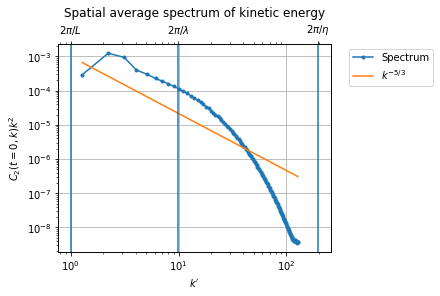

In [17]:
fig, ax = plt.subplots(constrained_layout=True)
spherical_coefficient= 4.0*np.pi*k*k/nb_of_modes
kinetic_energy = corr[0,:]*spherical_coefficient
ax.plot(k, kinetic_energy, '.-', label='Spectrum')
ax.plot(k, 1e-3*k**(-5.0/3.0), label=r'$k^{-5/3}$')
ax.set(xscale='log',yscale='log',xlabel=r'$k^\prime$', ylabel=r'$C_2(t=0,k) k^2$', title='Spatial average spectrum of kinetic energy')
vertical_lines = 2.0*np.pi* k_norm *np.array([1.0/L, 1.0/lmbda, 1.0/eta])
for line in vertical_lines : ax.axvline(x=line)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid()
ax2 = ax.twiny()
ax2.set(xscale='log', yscale='log', xlim = ax.get_xlim())
ax2.set_xticks(vertical_lines); ax2.set_xticklabels([r'$2\pi/L$', r'$2\pi/\lambda$', r'$2\pi/\eta$'])
plt.show()

# Plot spatio-temporal correlation function

<IPython.core.display.Javascript object>


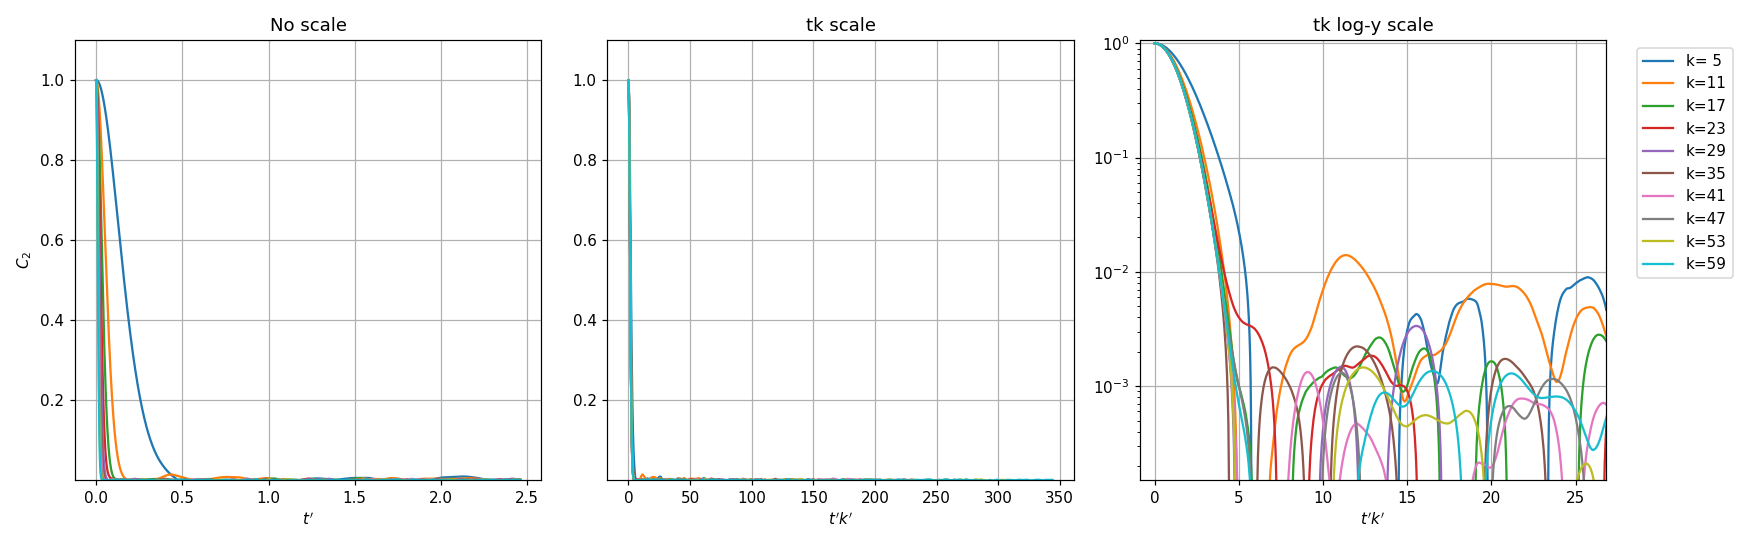

In [55]:
# tk1 = 0.0
# tk2 = 2.0

fig, (norm_scale, tk_scale, log_scale) = plt.subplots(nrows=1, ncols=3,figsize=(16,5))
for ik in indices_of_k_to_plot :
    time_slice = np.s_[0:5000]
    norm_scale.plot(t[time_slice]/t0, corr[time_slice,ik]*normalization[ik], '-')
    tk_scale.plot(t[time_slice]/t0*k[ik]/k_norm, corr[time_slice,ik]*normalization[ik], '-')
    log_scale.plot(t[time_slice]/t0*k[ik]/k_norm, corr[time_slice,ik]*normalization[ik], '-', label='k=%2.f' % (k[ik]))
norm_scale.set(ylim=[10e-6,1.1], yscale='linear', xscale='linear', title='No scale', ylabel=r'$C_2$', xlabel=r'$t^\prime$'); norm_scale.grid()
tk_scale.set(ylim=[10e-6,1.1], yscale='linear', xscale='linear', title='tk scale', xlabel=r'$t^\prime k^\prime$'); tk_scale.grid()
log_scale.set(ylim=[10e-6,10], yscale='log', xscale='linear', title='tk log-y scale', xlabel=r'$t^\prime k^\prime$'); log_scale.grid()
log_scale.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
fig.tight_layout()
plt.show()

# Plot temporal correlation (single point in x-space)

<IPython.core.display.Javascript object>


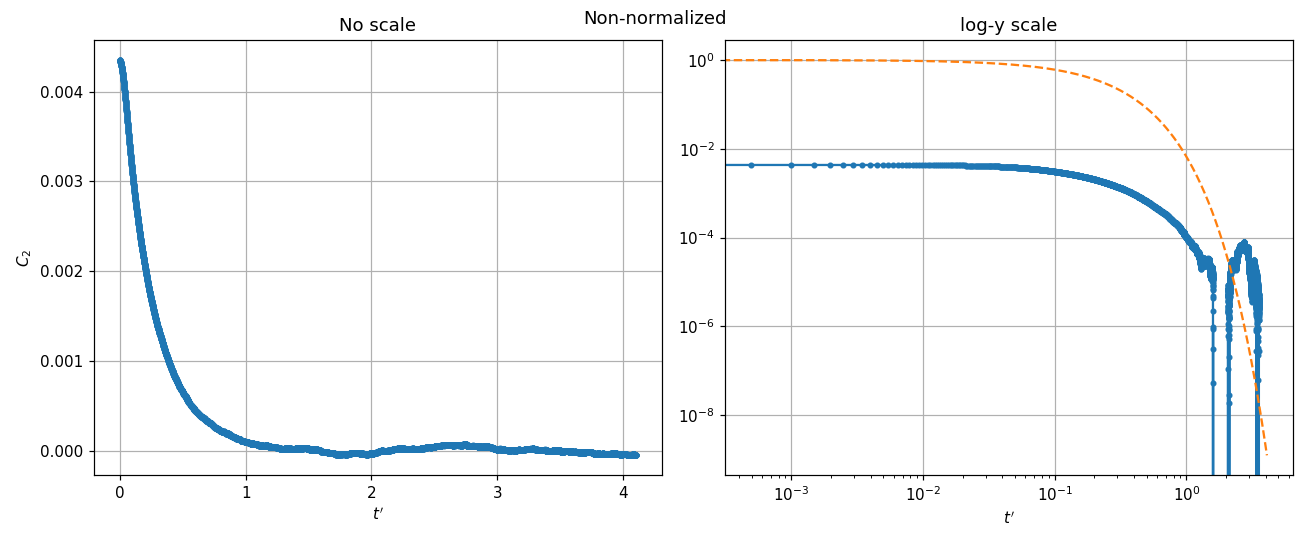

In [64]:
single_point_time_corr = np.sum((corr*spherical_coefficient)[:,0:15], axis=1)
fig, (norm_scale, log_scale) = plt.subplots(nrows=1, ncols=2,figsize=(12,5))
fig.suptitle('Non-normalized')
time_slice = np.s_[0:-1]
norm_scale.plot(t[time_slice]/t0, single_point_time_corr[time_slice], '.-')
log_scale.plot(t[time_slice]/t0, single_point_time_corr[time_slice], '.-')
log_scale.plot(t[time_slice]/t0, np.exp(-5.0*(t[time_slice]/t0)), '--')
norm_scale.set(yscale='linear', xscale='linear', title='No scale', ylabel=r'$C_2$', xlabel=r'$t^\prime$'); norm_scale.grid()
log_scale.set(title='log-y scale', yscale='log', xscale='log', xlabel=r'$t^\prime$'); log_scale.grid()
#log_scale.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


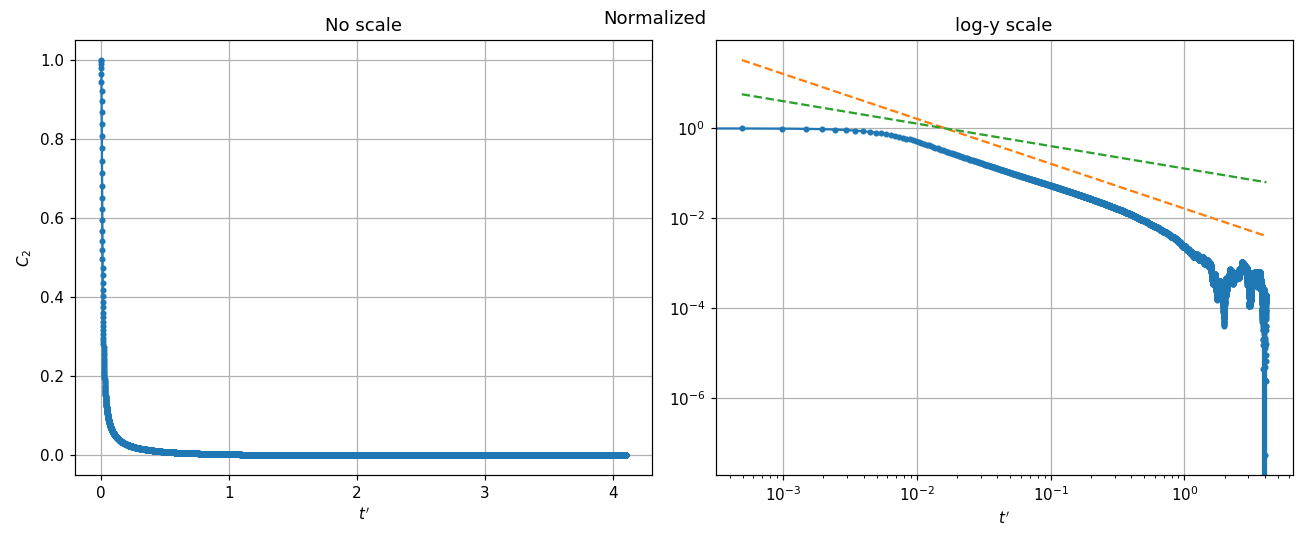

/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


In [72]:
fig, (norm_scale, log_scale) = plt.subplots(nrows=1, ncols=2,figsize=(12,5))
fig.suptitle('Normalized')
time_slice = np.s_[0:-1]
norm_scale.plot(t[time_slice]/t0, np.sum(corr*normalization, axis=1)[time_slice]/len(k), '.-')
log_scale.plot(t[time_slice]/t0, np.sum(corr*normalization, axis=1)[time_slice]/len(k), '.-')
log_scale.plot(t[time_slice]/t0, 1/t[time_slice], '--')
log_scale.plot(t[time_slice]/t0, 1/np.sqrt(t[time_slice]), '--')
#log_scale.plot(t[time_slice]/t0, 1/np.sqrt(t[time_slice]), '--')
norm_scale.set(yscale='linear', xscale='linear', title='No scale', ylabel=r'$C_2$', xlabel=r'$t^\prime$'); norm_scale.grid()
log_scale.set(title='log-y scale', yscale='log', xscale='log', xlabel=r'$t^\prime$'); log_scale.grid()
#log_scale.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
fig.tight_layout()
plt.show()

# FFT in time of correlation C_2(t,k)

In [90]:
delta = t[1]-t[0]
t_length = t.shape[0]
wavenumbers_length = k.shape[0]
omega = np.fft.fftfreq(t_length, delta)*2.0*np.pi
spectrum_of_correlation = np.ndarray(shape=(t_length, wavenumbers_length), dtype=complex)
for ik in list(range(wavenumbers_length)) :
    yf = np.fft.fft(corr[:,ik])
    spectrum_of_correlation[:, ik] = 1.0/t_length * yf
    
spectrum_of_single_point_correlation = 1.0/t_length * np.fft.fft(single_point_time_corr)
spectrum_of_single_point_correlation2 = np.sum(((k**(-2))*spectrum_of_correlation*spherical_coefficient)[:,:], axis=1)

<IPython.core.display.Javascript object>


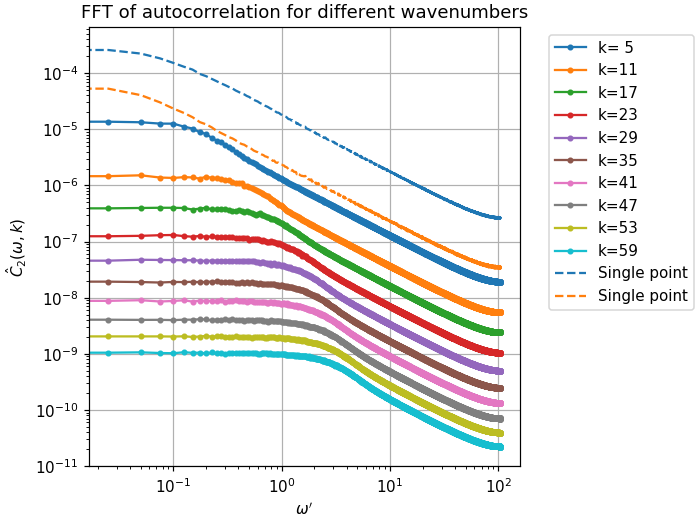

In [91]:
#plot \hat{C}_2(w, k) = FFT [C_2(t, k)]
fig, ax = plt.subplots(constrained_layout=True)
for ik in indices_of_k_to_plot :
    ax.plot(omega[0:t_length//2], np.absolute(spectrum_of_correlation[0:t_length//2, ik]), '.-', label='k=%2.f' % (k[ik]))
    #plt.plot(nu, 1.0/N * np.imag(yplot[:, ik]), label='k=%2.f' % k[ik])
#plt.xlim(-15, 15) 
#plt.plot(nu[1:N//2]*horizontal_scale, 10e-2*nu[1:N//2]**(-1), 'k-', label=r'$\nu^{-1}$')
ax.plot(omega[0:t_length//2], np.absolute(spectrum_of_single_point_correlation[0:t_length//2]), '--', label='Single point')
ax.plot(omega[0:t_length//2], np.absolute(spectrum_of_single_point_correlation2[0:t_length//2]), '--', label='Single point')
ax.set(xscale='log', yscale='log', xlabel=r'$\omega^\prime$', ylabel=r'$\hat{C}_2 (\omega, k)$', title='FFT of autocorrelation for different wavenumbers')
ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Single point frequency spectrum

<IPython.core.display.Javascript object>


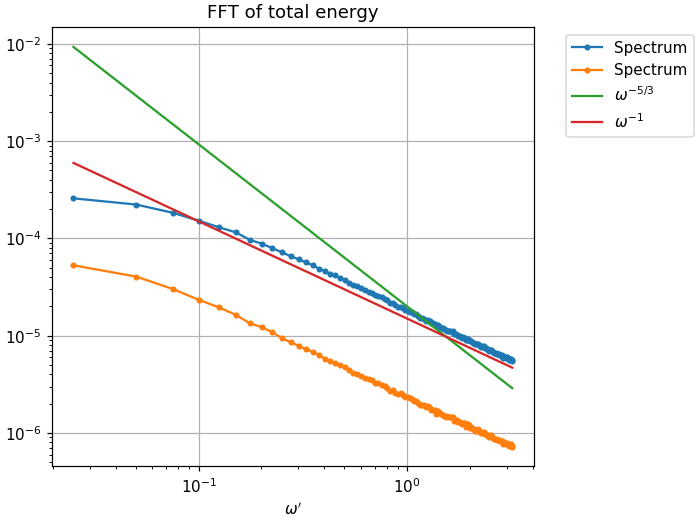

In [92]:
# tl = dissipation_rate**(-1/3)*lmbda**(2/3) #Kolmogorov time scale for lambda
# teta = dissipation_rate**(-1/3)*eta**(2/3) #Kolmogorov time scale for eta
# vertical_lines_kolmogorov = 2*np.pi*np.array([1.0/t0, 1.0/tl, 1.0/teta])*t0
# vertical_lines_sweeping = 2*np.pi*2*np.pi*np.array([1.0/L, 1.0/lmbda, 1.0/eta]) * k_norm

fig, ax = plt.subplots(constrained_layout=True)
total_energy_spectrum = np.zeros(shape=spectrum_of_correlation.shape[0], dtype=float)
range_of_k = list(range(wavenumbers_length))

ax.plot(omega[1:N//2], np.abs(spectrum_of_single_point_correlation[1:N//2]), '.-', label='Spectrum')
ax.plot(omega[1:N//2], np.abs(spectrum_of_single_point_correlation2[1:N//2]), '.-', label='Spectrum')
ax.plot(omega[1:N//2], 2.0e-5*omega[1:N//2]**(-5.0/3.0),label=r'$\omega^{-5/3}$')
ax.plot(omega[1:N//2], 15e-6*omega[1:N//2]**(-1.0), label=r'$\omega^{-1}$')
# for line in vertical_lines_kolmogorov : ax.axvline(x=line, c='blue', ls='--') #ax2
# for line in vertical_lines_sweeping : ax.axvline(x=line, c='red', ls='--') #ax3
ax.set(xscale='log', yscale='log', xlabel=r'$\omega^\prime$', title='FFT of total energy'); ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
# ax2 = ax.twiny()
# ax2.set(xscale='log', yscale='log', xlim = ax.get_xlim())
# ax2.set_xticks(vertical_lines_kolmogorov); ax2.set_xticklabels([r'$K_L$', r'$K_\lambda$', r'$K_\eta$'])
# ax2.tick_params(axis='x', colors='blue')

# ax3 = ax.twiny()
# ax3.set(xscale='log', yscale='log', xlim = ax.get_xlim())
# ax3.spines["top"].set_position(("axes", 1.2))
# ax3.set_xticks(vertical_lines_sweeping); ax3.set_xticklabels([r'$S_L$', r'$S_\lambda$', r'$S_\eta$'])
# ax3.tick_params(axis='x', colors='red')

plt.show()